In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!cp "/content/drive/My Drive/words.tgz" /content/
!cp "/content/drive/My Drive/ascii.tgz" /content/

In [4]:
!mkdir -p data
!mkdir -p data/words
!mkdir -p data/ascii
!tar -xf /content/words.tgz -C data/words
!tar -xf /content/ascii.tgz -C data/ascii

In [5]:
!head -20 /content/data/ascii/words.txt

#--- words.txt ---------------------------------------------------------------#
#
# iam database word information
#
# format: a01-000u-00-00 ok 154 1 408 768 27 51 AT A
#
#     a01-000u-00-00  -> word id for line 00 in form a01-000u
#     ok              -> result of word segmentation
#                            ok: word was correctly
#                            er: segmentation of word can be bad
#
#     154             -> graylevel to binarize the line containing this word
#     1               -> number of components for this word
#     408 768 27 51   -> bounding box around this word in x,y,w,h format
#     AT              -> the grammatical tag for this word, see the
#                        file tagset.txt for an explanation
#     A               -> the transcription for this word
#
a01-000u-00-00 ok 154 408 768 27 51 AT A
a01-000u-00-01 ok 154 507 766 213 48 NN MOVE


In [6]:
from tensorflow.keras.layers import StringLookup
from tensorflow import keras

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os

np.random.seed(42)
tf.random.set_seed(42)

In [7]:
base_path = "/content/data/ascii"
words_list = []

In [8]:
words = open(f"{base_path}/words.txt", "r").readlines()

In [9]:
print(words[0:10])

['#--- words.txt ---------------------------------------------------------------#\n', '#\n', '# iam database word information\n', '#\n', '# format: a01-000u-00-00 ok 154 1 408 768 27 51 AT A\n', '#\n', '#     a01-000u-00-00  -> word id for line 00 in form a01-000u\n', '#     ok              -> result of word segmentation\n', '#                            ok: word was correctly\n', '#                            er: segmentation of word can be bad\n']


In [10]:
#print(words[0:10])
for line in words:
    if line[0] == "#":
        continue
    if line.split(" ")[1] != "err":  # We don't need to deal with errored entries.
        words_list.append(line)

len(words_list)

np.random.shuffle(words_list)

In [11]:
print(words_list[0])

e04-030-04-08 ok 170 1489 1499 120 39 JJ sure



In [12]:
split_idx = int(0.9 * len(words_list))
print(split_idx)

86810


In [13]:
train_samples = words_list[:split_idx]
test_samples = words_list[split_idx:]

print(train_samples[0],test_samples[0])

e04-030-04-08 ok 170 1489 1499 120 39 JJ sure
 b01-136-01-01 ok 182 511 915 132 91 JJ able



In [14]:
val_split_idx = int(0.5 * len(test_samples))
validation_samples = test_samples[:val_split_idx]
test_samples = test_samples[val_split_idx:]


assert len(words_list) == len(train_samples) + len(validation_samples) + len(
    test_samples
)

print(f"Total training samples: {len(train_samples)}")
print(f"Total validation samples: {len(validation_samples)}")
print(f"Total test samples: {len(test_samples)}")

Total training samples: 86810
Total validation samples: 4823
Total test samples: 4823


In [15]:
print(val_split_idx)

4823


In [16]:
print(validation_samples[0],test_samples[0])

b01-136-01-01 ok 182 511 915 132 91 JJ able
 g01-067-03-02 ok 152 832 1308 286 82 VBN altered



In [17]:
base_path="data"
base_image_path = os.path.join(base_path, "words")

In [18]:
def get_image_paths_and_labels(samples):
  paths = []
  corrected_samples = []
  for (i, file_line) in enumerate(samples):
    line_split = file_line.strip()
    #print(line_split)
    line_split = line_split.split(" ")
    #print(line_split)

    # Each line split will have this format for the corresponding image:
    # part1/part1-part2/part1-part2-part3.png
    image_name = line_split[0]
    part1 = image_name.split("-")[0]
    part2 = image_name.split("-")[1]
    img_path = os.path.join(base_image_path, part1, part1 + "-" + part2, image_name + ".png")
    if os.path.exists(img_path):
      if os.path.getsize(img_path): # Now it's safe to check the size
        paths.append(img_path)
        corrected_samples.append(file_line.split("\n")[0])
        # print(corrected_samples[0])
    else:
      # If the file doesn't exist, consider printing a warning or logging the error
        print(f"Warning: Image file not found: {img_path}")


  return paths, corrected_samples

In [19]:
train_img_paths, train_labels = get_image_paths_and_labels(train_samples)
validation_img_paths, validation_labels = get_image_paths_and_labels(validation_samples)
test_img_paths, test_labels = get_image_paths_and_labels(test_samples)

In [20]:
print(train_img_paths[0], train_labels[0])

data/words/e04/e04-030/e04-030-04-08.png e04-030-04-08 ok 170 1489 1499 120 39 JJ sure


In [21]:
print(validation_img_paths[0], validation_labels[0])

data/words/b01/b01-136/b01-136-01-01.png b01-136-01-01 ok 182 511 915 132 91 JJ able


In [22]:

train_labels_cleaned = []
characters = set()
max_len = 0

for label in train_labels:
    label = label.split(" ")[-1].strip()
    for char in label:
        characters.add(char)

    max_len = max(max_len, len(label))
    train_labels_cleaned.append(label)

print("Maximum length: ", max_len)
print("Vocab size: ", len(characters))

# Check some label samples.
train_labels_cleaned[:10]

Maximum length:  21
Vocab size:  78


['sure',
 'he',
 'during',
 'of',
 'booty',
 'gastronomy',
 'boy',
 'The',
 'and',
 'in']

In [23]:
import pickle

with open('characters.pkl', 'wb') as f:
  pickle.dump(characters, f)

In [24]:
import pickle
with open('characters.pkl', 'rb') as f:
   characters = pickle.load(f)

In [25]:
characters

{'!',
 '"',
 '#',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ':',
 ';',
 '?',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z'}

In [26]:
vocab1=list(characters)


import pickle

with open('vocab1.pkl', 'wb') as f:
  pickle.dump(vocab1, f)

import pickle
with open('vocab1.pkl', 'rb') as f:
   vocab1= pickle.load(f)


In [27]:
vocab1

['?',
 'k',
 '5',
 'w',
 'E',
 'y',
 'Y',
 'O',
 'n',
 'R',
 'A',
 'j',
 '9',
 '.',
 '7',
 'r',
 '-',
 '0',
 'U',
 '3',
 'D',
 "'",
 'H',
 'C',
 ',',
 'K',
 'q',
 'Q',
 '8',
 'W',
 'L',
 '#',
 'J',
 'o',
 'z',
 'T',
 '+',
 'X',
 'l',
 'i',
 '(',
 'S',
 'N',
 'B',
 '/',
 'u',
 '&',
 'm',
 'a',
 '"',
 'P',
 't',
 'c',
 ')',
 'f',
 'b',
 'I',
 'Z',
 'G',
 '6',
 'p',
 '*',
 ';',
 'h',
 'V',
 'M',
 '2',
 'x',
 's',
 '!',
 'F',
 'v',
 ':',
 '1',
 'e',
 'g',
 '4',
 'd']

In [28]:
def clean_labels(labels):
    cleaned_labels = []
    for label in labels:
        label = label.split(" ")[-1].strip()
        cleaned_labels.append(label)
    return cleaned_labels


validation_labels_cleaned = clean_labels(validation_labels)
test_labels_cleaned = clean_labels(test_labels)

In [29]:
test_labels_cleaned[0:10]

['altered',
 'Here',
 "'",
 'the',
 'It',
 'up',
 'edges',
 'The',
 'position',
 'scratched']

In [30]:
AUTOTUNE = tf.data.AUTOTUNE

# Mapping characters to integers.
char_to_num = StringLookup(vocabulary=vocab1, mask_token=None)

# Mapping integers back to original characters.
num_to_char = StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

In [31]:
def distortion_free_resize(image, img_size):
    w, h = img_size
    image = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True)

    # Check tha amount of padding needed to be done.
    pad_height = h - tf.shape(image)[0]
    pad_width = w - tf.shape(image)[1]

    # Only necessary if you want to do same amount of padding on both sides.
    if pad_height % 2 != 0:
        height = pad_height // 2
        pad_height_top = height + 1
        pad_height_bottom = height
    else:
        pad_height_top = pad_height_bottom = pad_height // 2

    if pad_width % 2 != 0:
        width = pad_width // 2
        pad_width_left = width + 1
        pad_width_right = width
    else:
        pad_width_left = pad_width_right = pad_width // 2

    image = tf.pad(
        image,
        paddings=[
            [pad_height_top, pad_height_bottom],
            [pad_width_left, pad_width_right],
            [0, 0],
        ],
    )

    image = tf.transpose(image, perm=[1, 0, 2])
    image = tf.image.flip_left_right(image)
    return image

In [32]:
batch_size = 64
padding_token = 99
image_width = 128
image_height = 32

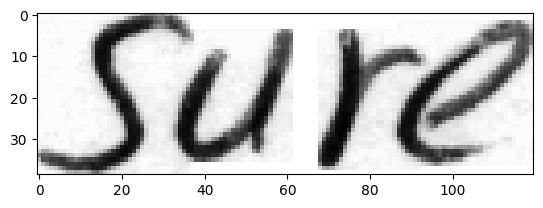

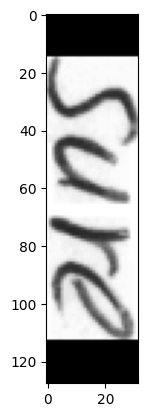

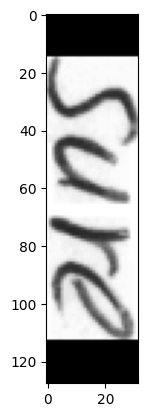

In [33]:
#def preprocess_image(image_path, img_size=(image_width, image_height)):
image = tf.io.read_file(train_img_paths[0])
#plt.imshow(image)
#plt.show()
image = tf.image.decode_png(image, 1)
plt.imshow(image,cmap="gray")
plt.show()
image = distortion_free_resize(image,(image_width, image_height))    #calling above function  here
plt.imshow(image,cmap="gray")
plt.show()
image = tf.cast(image, tf.float32) / 255.0
 #   return image
plt.imshow(image,cmap="gray")
plt.show()

In [35]:


print(train_labels_cleaned[0])
label = char_to_num(tf.strings.unicode_split(train_labels_cleaned[0], input_encoding="UTF-8"))
print(label)
length = tf.shape(label)[0]
print(length)
pad_amount = max_len - length
print(pad_amount)
label = tf.pad(label, paddings=[[0, pad_amount]], constant_values=padding_token)
print(label)




sure
tf.Tensor([69 46 16 75], shape=(4,), dtype=int64)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(17, shape=(), dtype=int32)
tf.Tensor([69 46 16 75 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99], shape=(21,), dtype=int64)


In [36]:
batch_size = 32
padding_token = 99
image_width = 128
image_height = 32


def preprocess_image(image_path, img_size=(image_width, image_height)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, 1)
    image = distortion_free_resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.0
    return image


def vectorize_label(label):
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    length = tf.shape(label)[0]
    pad_amount = max_len - length
    label = tf.pad(label, paddings=[[0, pad_amount]], constant_values=padding_token)
    return label


def process_images_labels(image_path, label):
    image = preprocess_image(image_path)
    label = vectorize_label(label)
    return {"image": image, "label": label}

def prepare_dataset(image_paths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels)).map(
        process_images_labels, num_parallel_calls=AUTOTUNE
    )
    return dataset.batch(batch_size).cache().prefetch(AUTOTUNE)

In [37]:
train_ds = prepare_dataset(train_img_paths, train_labels_cleaned)
validation_ds = prepare_dataset(validation_img_paths, validation_labels_cleaned)
test_ds = prepare_dataset(test_img_paths, test_labels_cleaned)


print(train_ds)
print(validation_ds)
print(test_ds)

<_PrefetchDataset element_spec={'image': TensorSpec(shape=(None, None, None, 1), dtype=tf.float32, name=None), 'label': TensorSpec(shape=(None, None), dtype=tf.int64, name=None)}>
<_PrefetchDataset element_spec={'image': TensorSpec(shape=(None, None, None, 1), dtype=tf.float32, name=None), 'label': TensorSpec(shape=(None, None), dtype=tf.int64, name=None)}>
<_PrefetchDataset element_spec={'image': TensorSpec(shape=(None, None, None, 1), dtype=tf.float32, name=None), 'label': TensorSpec(shape=(None, None), dtype=tf.int64, name=None)}>


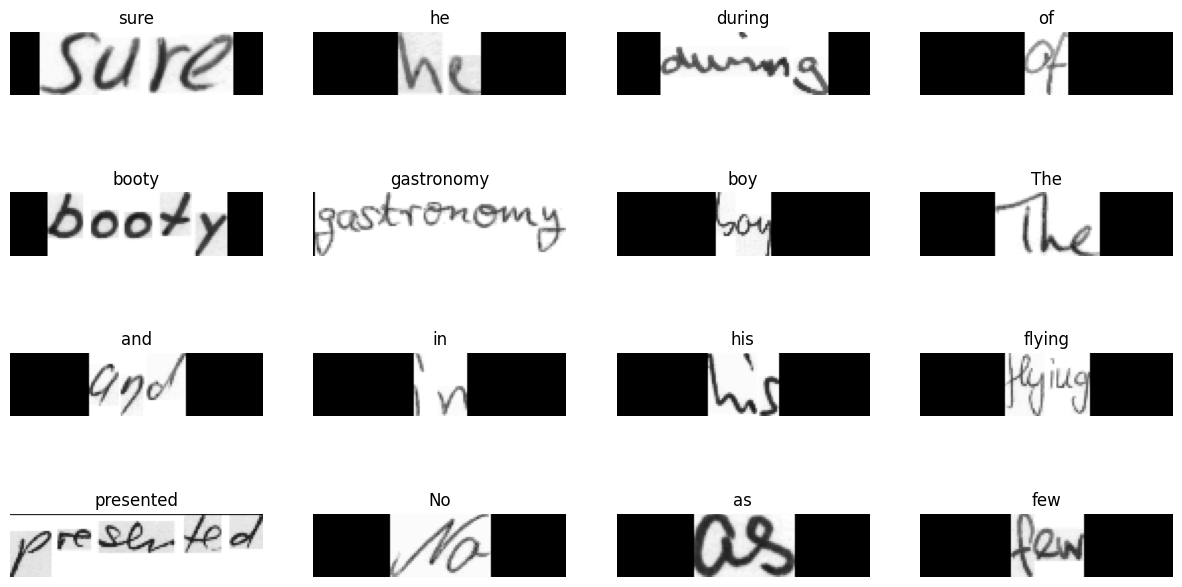

In [38]:
for data in train_ds.take(1):
    images, labels = data["image"], data["label"]

    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    for i in range(16):
        img = images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        # Gather indices where label!= padding_token.
        label = labels[i]
        indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
        # Convert to string.
        label = tf.strings.reduce_join(num_to_char(indices))
        label = label.numpy().decode("utf-8")

        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")


plt.show()

In [39]:
class CTCLayer(keras.layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        return y_pred


def build_model():

    input_img = keras.Input(shape=(image_width, image_height, 1), name="image")
    labels = keras.layers.Input(name="label", shape=(None,))


    x = keras.layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = keras.layers.MaxPooling2D((2, 2), name="pool1")(x)


    x = keras.layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = keras.layers.MaxPooling2D((2, 2), name="pool2")(x)


    new_shape = ((image_width // 4), (image_height // 4) * 64)
    x = keras.layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = keras.layers.Dense(64, activation="relu", name="dense1")(x)
    x = keras.layers.Dropout(0.2)(x)


    x = keras.layers.Bidirectional(
        keras.layers.LSTM(128, return_sequences=True, dropout=0.25)
    )(x)
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(64, return_sequences=True, dropout=0.25)
    )(x)
    x = keras.layers.Dense(
        len(char_to_num.get_vocabulary()) + 2, activation="softmax", name="dense2"
    )(x)


    output = CTCLayer(name="ctc_loss")(labels, x)


    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="handwriting_recognizer"
    )

    opt = keras.optimizers.Adam()

    model.compile(optimizer=opt)
    return model



model = build_model()
model.summary()

Model: "handwriting_recognizer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)        │ (None, 128, 32, 1)     │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 128, 32, 32)    │            320 │ image[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 64, 16, 32)     │              0 │ Conv1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv2 (Conv2D)            │ (None, 64, 16, 64)     │         18,496 │ pool1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool2 (MaxPooling2D)      │ (None, 32, 8, 64)      │              0 │ Conv2[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 32, 512)        │              0 │ pool2[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense1 (Dense)            │ (None, 32, 64)         │         32,832 │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 32, 64)         │              0 │ dense1[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 32, 256)        │        197,632 │ dropout[0][0]          │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_1           │ (None, 32, 128)        │        164,352 │ bidirectional[0][0]    │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ label (InputLayer)        │ (None, None)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense2 (Dense)            │ (None, 32, 81)         │         10,449 │ bidirectional_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ ctc_loss (CTCLayer)       │ (None, 32, 81)         │              0 │ label[0][0],           │
│                           │                        │                │ dense2[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 424,081 (1.62 MB)

 Trainable params: 424,081 (1.62 MB)

 Non-trainable params: 0 (0.00 B)

In [40]:
validation_images = []
validation_labels = []

for batch in validation_ds:
    validation_images.append(batch["image"])
    validation_labels.append(batch["label"])

In [41]:
validation_images

[<tf.Tensor: shape=(32, 128, 32, 1), dtype=float32, numpy=
 array([[[[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],
 
         [[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],
 
         [[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],
 
         ...,
 
         [[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],
 
         [[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],
 
         [[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]]],
 
 
        [[[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],
 
         [[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],
 
         [

In [42]:
def calculate_edit_distance(labels, predictions):

    saprse_labels = tf.cast(tf.sparse.from_dense(labels), dtype=tf.int64)

    input_len = np.ones(predictions.shape[0]) * predictions.shape[1]
    predictions_decoded = keras.backend.ctc_decode(
        predictions, input_length=input_len, greedy=True
    )[0][0][:, :max_len]
    sparse_predictions = tf.cast(
        tf.sparse.from_dense(predictions_decoded), dtype=tf.int64
    )

    edit_distances = tf.edit_distance(
        sparse_predictions, saprse_labels, normalize=False
    )
    return tf.reduce_mean(edit_distances)


class EditDistanceCallback(keras.callbacks.Callback):
    def __init__(self, pred_model):
        super().__init__()
        self.prediction_model = pred_model

    def on_epoch_end(self, epoch, logs=None):
        edit_distances = []

        for i in range(len(validation_images)):
            labels = validation_labels[i]
            predictions = self.prediction_model.predict(validation_images[i])
            edit_distances.append(calculate_edit_distance(labels, predictions).numpy())

        print(
            f"Mean edit distance for epoch {epoch + 1}: {np.mean(edit_distances):.4f}"
        )

In [43]:
model = build_model()
prediction_model = keras.models.Model(
    inputs=model.input[0],
    outputs=model.get_layer(name="dense2").output
)
edit_distance_callback = EditDistanceCallback(prediction_model)

In [44]:
epochs = 25
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=epochs
)

Epoch 1/25
2713/2713 ━━━━━━━━━━━━━━━━━━━━ 155s 54ms/step - loss: 484.6998 - val_loss: 352.7109
Epoch 2/25
2713/2713 ━━━━━━━━━━━━━━━━━━━━ 139s 32ms/step - loss: 327.9772 - val_loss: 267.4128
Epoch 3/25
2713/2713 ━━━━━━━━━━━━━━━━━━━━ 88s 32ms/step - loss: 254.0433 - val_loss: 200.4625
Epoch 4/25
2713/2713 ━━━━━━━━━━━━━━━━━━━━ 142s 33ms/step - loss: 192.9599 - val_loss: 156.9265
Epoch 5/25
2713/2713 ━━━━━━━━━━━━━━━━━━━━ 90s 33ms/step - loss: 156.9774 - val_loss: 132.9045
Epoch 6/25
2713/2713 ━━━━━━━━━━━━━━━━━━━━ 88s 32ms/step - loss: 137.5909 - val_loss: 126.1339
Epoch 7/25
2713/2713 ━━━━━━━━━━━━━━━━━━━━ 143s 33ms/step - loss: 124.3304 - val_loss: 111.8441
Epoch 8/25
2713/2713 ━━━━━━━━━━━━━━━━━━━━ 88s 32ms/step - loss: 114.7971 - val_loss: 106.0262
Epoch 9/25
2713/2713 ━━━━━━━━━━━━━━━━━━━━ 147s 34ms/step - loss: 107.9125 - val_loss: 98.6284
Epoch 10/25
2713/2713 ━━━━━━━━━━━━━━━━━━━━ 93s 34ms/step - loss: 102.6849 - val_loss: 95.9323
Epoch 11/25
2713/2713 ━━━━━━━━━━━━━━━━━━━━ 92s 34ms/step

In [1]:
epochs = 25
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=epochs
)

NameError: name 'model' is not defined

In [ ]:
prediction_model.save("handwritten_text_50.keras")

In [ ]:
!cp "/content/drive/My Drive/handwritten_text_50.keras" /content/

import tensorflow as tf
from tensorflow import keras
model1 = keras.models.load_model('handwritten_text_50.keras')

In [ ]:
from keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
def predict_medicine_name(model, img_path, label_encoder, target_size=(64, 64)):
    # Load and preprocess the image
    img = load_img(img_path, target_size=target_size)
    img_array = img_to_array(img) / 255.0  # Normalize the image
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Make prediction
    prediction = model.predict(img_array)
    predicted_class_index = np.argmax(prediction, axis=1)[0]
    predicted_class = label_encoder.inverse_transform([predicted_class_index])[0]

    return predicted_class

model = keras.models.load_model('handwritten_text_50.keras')

# Predict on a new image
new_image_path = '/content/drive/My Drive/prescription/Doctor’s Handwritten Prescription BD dataset/Validation/validation_words/693.png'
predicted_medicine_name = predict_medicine_name(model, new_image_path, label_encoder)

img=load_img(new_image_path)
plt.imshow(img)
print("Predicted Medicine Name:", predicted_medicine_name)

In [ ]:

def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]

    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_len
    ]

    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

for batch in test_ds.take(1):
    batch_images = batch["image"]
    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    preds = model1.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    for i in range(16):
        img = batch_images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")

plt.show()

In [ ]:

for batch in test_ds.take(1):

    batch_images = batch["image"]
    _, ax = plt.subplots(5, 5, figsize=(15, 8))

    preds = model1.predict(batch_images)

    pred_texts = decode_batch_predictions(preds)
    print(pred_texts)

    for i in range(25):
        img = batch_images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        title = f"Prediction: {pred_texts[i]}"
        ax[i // 5, i % 5].imshow(img, cmap="gray")
        ax[i // 5, i % 5].set_title(title)
        ax[i // 5, i % 5].axis("off")

plt.show()

In [ ]:
from google.colab import files
files.download("handwritten_text_50.keras")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
prediction_model.save('/content/drive/MyDrive/handwritten_text_50.keras')

In [ ]:
wrong_characters=10

In [ ]:
total_number_characters=260

In [ ]:
WER=(100*wrong_characters)/(total_number_characters)

In [ ]:
def distortion_free_resize(image, img_size):
    w, h = img_size
    image = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True)

    # Check tha amount of padding needed to be done.
    pad_height = h - tf.shape(image)[0]
    pad_width = w - tf.shape(image)[1]

    # Only necessary if you want to do same amount of padding on both sides.
    if pad_height % 2 != 0:
        height = pad_height // 2
        pad_height_top = height + 1
        pad_height_bottom = height
    else:
        pad_height_top = pad_height_bottom = pad_height // 2

    if pad_width % 2 != 0:
        width = pad_width // 2
        pad_width_left = width + 1
        pad_width_right = width
    else:
        pad_width_left = pad_width_right = pad_width // 2

    image = tf.pad(
        image,
        paddings=[
            [pad_height_top, pad_height_bottom],
            [pad_width_left, pad_width_right],
            [0, 0],
        ],
    )

    image = tf.transpose(image, perm=[1, 0, 2])
    image = tf.image.flip_left_right(image)
    return image

batch_size = 64
padding_token = 99
image_width = 128
image_height = 32


def preprocess_image(image_path, img_size=(image_width, image_height)):     #called 4th
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, 1)
    image = distortion_free_resize(image, img_size)    #calling above function  here
    image = tf.cast(image, tf.float32) / 255.0
    return image


def vectorize_label(label):
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))              #called 3rd
    length = tf.shape(label)[0]
    pad_amount = max_len - length
    label = tf.pad(label, paddings=[[0, pad_amount]], constant_values=padding_token)
    return label


def process_images_labels(image_path, label):                     #called 2nd
    image = preprocess_image(image_path)
    label = vectorize_label(label)
    return {"image": image, "label": label}






def prepare_dataset(image_paths, labels):           #called 1
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels)).map(
        process_images_labels, num_parallel_calls=AUTOTUNE
    )
    return dataset.batch(batch_size).cache().prefetch(AUTOTUNE)

test_img_paths[0]="p5.png"
print(len(test_img_paths))
test_ds1 = prepare_dataset(test_img_paths, test_labels_cleaned)

In [ ]:

file1 = open("img_names_sequence.txt","r+")
print( "the image names are  ")
print(file1.read())
print()

In [ ]:
with open("img_names_sequence.txt") as file_in:
    lines = []
    for line in file_in:
        line = line.strip()
        lines.append(line)

In [ ]:
print(lines)

In [ ]:
len_test=len(lines)
for kk in range(len_test):
    test_img_paths[kk]=lines[kk]

print(test_img_paths[0:60])


In [ ]:

def distortion_free_resize(image, img_size):
    w, h = img_size
    image = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True)

    # Check tha amount of padding needed to be done.
    pad_height = h - tf.shape(image)[0]
    pad_width = w - tf.shape(image)[1]

    # Only necessary if you want to do same amount of padding on both sides.
    if pad_height % 2 != 0:
        height = pad_height // 2
        pad_height_top = height + 1
        pad_height_bottom = height
    else:
        pad_height_top = pad_height_bottom = pad_height // 2

    if pad_width % 2 != 0:
        width = pad_width // 2
        pad_width_left = width + 1
        pad_width_right = width
    else:
        pad_width_left = pad_width_right = pad_width // 2

    image = tf.pad(
        image,
        paddings=[
            [pad_height_top, pad_height_bottom],
            [pad_width_left, pad_width_right],
            [0, 0],
        ],
    )

    image = tf.transpose(image, perm=[1, 0, 2])
    image = tf.image.flip_left_right(image)
    return image

#batch_size = 64
#padding_token = 99
#image_width = 128
#image_height = 32


batch_size = 64
padding_token = 99
image_width = 128
image_height = 32


def preprocess_image(image_path, img_size=(image_width, image_height)):     #called 4th
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, 1)
    image = distortion_free_resize(image, img_size)    #calling above function  here
    image = tf.cast(image, tf.float32) / 255.0
    return image


def vectorize_label(label):
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))              #called 3rd
    length = tf.shape(label)[0]
    pad_amount = max_len - length
    label = tf.pad(label, paddings=[[0, pad_amount]], constant_values=padding_token)
    return label


def process_images_labels(image_path, label):                     #called 2nd
    image = preprocess_image(image_path)
    label = vectorize_label(label)
    return {"image": image, "label": label}






def prepare_dataset(image_paths, labels):           #called 1
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels)).map(
        process_images_labels, num_parallel_calls=AUTOTUNE
    )
    return dataset.batch(batch_size).cache().prefetch(AUTOTUNE)

#test_img_paths[0]="line0word1.jpg"

#test_img_paths[1]="line0word2.jpg"

#test_img_paths[2]="line0word3.jpg"

print("length of the test list is",len(test_img_paths))

test_ds1 = prepare_dataset(test_img_paths, test_labels_cleaned)
#  Let's check results on some test samples.
for batch in test_ds1.take(1):
    #print(batch)
    batch_images = batch["image"]
    _, ax = plt.subplots(5, 5, figsize=(15, 8))

    preds = model1.predict(batch_images)
    #print(preds)
    pred_texts = decode_batch_predictions(preds)
    print(pred_texts)

    for i in range(25):
        img = batch_images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        title = f"Prediction: {pred_texts[i]}"
        ax[i // 5, i % 5].imshow(img, cmap="gray")
        ax[i // 5, i % 5].set_title(title)
        ax[i // 5, i % 5].axis("off")

plt.show()